## [INF1951] Projeto Final 2

### Tema: Aplicação de redes neurais no processo de análise dos movimentos contra a desigualdade de gênero nas redes sociais.

****Sobre:****
Este documento corresponde a análise dos tweets sobre desigualdade de gênero proposto pelo projeto de tema descrito acima.

As seguintes ****etapas**** foram realizadas ao longo deste notebook para a conclusão do projeto e da análise prospota:

    1- Coleta dos dados do twitter referente ao tema "desigualdade de genêro", utilizando como parâmetros da query hashtags e keywords. Foram coletados tweets a partir de janeiro de 2015 até setembro de 2021. Totalizando 9436 tweets na base de dados.

    2- Pré-processamento dos dados para prepará-los para as análises. Foram feitos os seguintes tratamentos:

        ● Remoção de linhas duplicadas (comuns por conta dos retweets).

        ● Remoção de stopwords e caracteres indesejados.

        ● Tokenização.

    3- Análise exploratória com objetivo de extrair algumas informações relevantes para a pesquisa, foram elas:

        ● Média de caracteres por tweet.

        ● Usuários que mais postaram sobre o tema.

        ● O tweet mais curtido e o mais retweetado.

        ● ECDF da quantidade de tweets, retweets e curtidas.
        
        ● Correlação entre as colunas de quantidade de curtidas, quantidade de retweets e tamanho do tweet.

        ● Palavras mais utilizadas.

        ● Hashtags mais utilizadas.

        ● Índices de tweets por ano.

        ● Locais mais comuns de onde foram postados os tweets, gerando o heatmap.


    4 - Aplicações de NLP:

        ● Análise do conteúdo das postagens utilizando n-grams. São apresentados os bigramas e trigramas das palavras co-ocorrentes mas frequentes e suas respectivas ocorrências.

        ● Análise de sentimentos dos tweets utilizando a abordagem Bag of Words para o treino do modelo e o algoritmo Naive Bayes Multinomial. 
    
    5 - Análise com Rede Neural:
        
        ● Previsão de engajamento em postagens.

#### Aluna: Nathalia Mariz de Almeida Salgado Inácio | Matrícula: 1520763
#### Orientador: Hélio Cortes Vieira Lopes

### Imports

In [1]:
# Basic Imports
from IPython.core.interactiveshell import InteractiveShell
from collections import ChainMap
import matplotlib.pyplot as plt
from unidecode import unidecode
from datetime import datetime
import jupyterthemes as jt
from PIL import Image
import collections
import toolz as fp
import pandas as pd     
import numpy as np
import functools
import itertools
import operator
import warnings
import squarify 
import base64
import folium
import time
import json
import yaml
import os
import re

# Tweets manipulation
from searchtweets import load_credentials
from searchtweets import gen_rule_payload
from searchtweets import ResultStream
import tweepy

# Plotting and Visualization
from statsmodels.distributions.empirical_distribution import ECDF
from IPython.display import display
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# NLTK 
from nltk.stem.lancaster import LancasterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize 
from nltk.util import ngrams
from nltk import bigrams
import nltk

#Skylearn 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import cross_val_predict
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn import svm

# TextBlob
from textblob import TextBlob

# Translation
from deep_translator import GoogleTranslator

# Map plotting
from geopy.geocoders import Nominatim
from folium import plugins
import folium

#Neural Network prediction
from operator import itemgetter
import feedparser

# Configuration
%matplotlib inline
sns.set()
%config InlineBackend.figure_format = 'svg' 
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')
nltk.download('rslp')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package rslp to
[nltk_data]     /Users/nathaliainacio/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nathaliainacio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nathaliainacio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Buscando e armazenando os dados dos tweets

***Observação:***

A maior parte do código desta seção deve ficar comentado para não serem feitas requisições desnecessárias a API do twitter.

### Configurações e credenciais

Configurações de endpoint e credenciais de acesso ao enviroment criado dentro da API para o desenvolvimento do projeto.

In [2]:
# config = dict(
#     search_tweets_api = dict(
#         account_type = 'premium',
#         endpoint = 'https://api.twitter.com/1.1/tweets/search/fullarchive/staging.json',
#         consumer_key = 'yDYE90wYsUCSkVYLxznO7dUg0',
#         consumer_secret = '2x9IKtzodDzX7qSOUI2yMlgH2EM3RGWIqiVMrCNd3FseS0c2IJ'
#     )
# )
# with open('twitter_keys_fullarchive.yaml', 'w') as config_file:
#     yaml.dump(config, config_file, default_flow_style=False)

In [3]:
# premium_search_args = load_credentials("twitter_keys_fullarchive.yaml",
#                                        yaml_key="search_tweets_api",
#                                        env_overwrite=False)
# print(premium_search_args)

### Definindo as keywords, ano, e idioma da query

***Observação:***

Como há uma limitação de quantidade de tweets por request, foram feitas mais de uma requisição a API, mantendo as keywords e mudando as datas.

As palavras-chaves utilizadas foram:

● `Desigualdade de gênero`
● `Divisão sexual do trabalho`
● `Diferença salarial`
● `Equidade de gênero`
● `Igualdade de gênero`
● `#DesafioDaIgualdade`
● `#DeixaElaTrabalhar`
●

E buscou-se por tweets a partir de janeiro de 2015 até setembro de 2021.

In [4]:
# query = "lang:pt(#DeixaElaTrabalhar OR #DesafioDaIgualdade OR (desigualdade de gênero) OR (desigualdade de genero) OR (divisão sexual do trabalho) OR (divisao sexual do trabalho) OR (diferença salarial) OR (diferenca salarial) OR (equidade de gênero) OR (equidade de genero) OR (igualdade de gênero) OR (igualdade de genero))"
# rule = gen_rule_payload(query, results_per_call=500, from_date="2021-01-01", to_date="2021-09-30")

In [5]:
# rs = ResultStream(rule_payload=rule,
#                   max_results=3000,
#                   **premium_search_args)

### Importando os tweets encontrados para um json

***Observação:***

Pela mesma limitação descrita acima, cada request obteve seu próprio json, e todos foram concatenados em um único json denominado: `tweetsData`.

In [6]:
# with open('tweetsData2021.jsonl', 'a', encoding='utf-8') as f:
#     for tweet in rs.stream():
#         json.dump(tweet, f)
#         f.write('\n')

In [7]:
# jsonFiles=['tweetsData2015.jsonl', 'tweetsData2016.jsonl', 'tweetsData2017.jsonl', 'tweetsData2018.jsonl', 
#            'tweetsData2019.jsonl', 'tweetsData2020.jsonl', 'tweetsData2021.jsonl']


# data = []

# def merge_JsonFiles(files):
#     result = list()
#     for file in files:
#         with open(file) as f:
#             for line in f:
#                 data.append(json.loads(line))

    
# merge_JsonFiles(jsonFiles)

In [8]:
# with open('tweetsData.jsonl', 'a', encoding='utf-8') as f:
#     for tweet in data:
#         json.dump(tweet, f)
#         f.write('\n')

### Transformando o json em um dataframe

***Observação:***

Para melhor visualização e manipulação dos dados pertencentes ao json `tweetsData`, este foi transformado em um data frame.

In [9]:
def parseMultipleJSON(lines):
    lines = ''.join(lines).split('}{')
    data = [json.loads('%s}' % line) if idx == 0 else json.loads('{%s' % line) if idx == len(lines)-1 else json.loads('{%s}' % line) for idx, line in enumerate(lines)]
    return data

In [10]:
with open('tweetsData.jsonl','r') as json_file:
    lines = json_file.readlines()
    lines = [line.strip("\n") for line in lines]
    data = parseMultipleJSON(lines)

tweets_df = pd.DataFrame(data)
pd.set_option('display.max_colwidth', None)
tweets_df.head()

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,matching_rules,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,retweeted_status,extended_entities,display_text_range,extended_tweet,scopes
0,Wed Dec 30 19:50:53 +0000 2015,682287762406510592,682287762406510592,#ProjetoTheBridge:A Mulher Angolana e o Desenvolvimento Sustentável tem objetivo de construir a igualdade de gênero.https://t.co/gTCEWfxrA3,"<a href=""http://www.hootsuite.com"" rel=""nofollow"">Hootsuite</a>",False,NaN,None,NaN,None,...,[{'tag': None}],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Wed Dec 30 18:45:20 +0000 2015,682271265546096640,682271265546096640,Como a igualdade de género fez da Suécia um país mais rico https://t.co/NJM7L7WbmY,"<a href=""http://www.facebook.com/twitter"" rel=""nofollow"">Facebook</a>",False,NaN,None,NaN,None,...,[{'tag': None}],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Wed Dec 30 16:57:38 +0000 2015,682244163182567424,682244163182567424,Como a igualdade de género fez da Suécia um país mais rico https://t.co/zUAiVHuZ5T,"<a href=""http://www.facebook.com/twitter"" rel=""nofollow"">Facebook</a>",False,NaN,None,NaN,None,...,[{'tag': None}],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Wed Dec 30 16:56:41 +0000 2015,682243921703878656,682243921703878656,Como a igualdade de género fez da Suécia um país mais rico https://t.co/mGXBHv9Egd,"<a href=""http://www.facebook.com/twitter"" rel=""nofollow"">Facebook</a>",False,NaN,None,NaN,None,...,[{'tag': None}],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Wed Dec 30 15:42:09 +0000 2015,682225168345870336,682225168345870336,"@Camy_Dragen exatamente! a tão famigerada igualdade só vai existir quando os papéis de gênero ñ existirem +, e isso serve pro homem tbm","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False,6.822250e+17,682224998820483072,241354036.0,241354036,...,[{'tag': None}],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Manipulando algumas colunas do dataframe

Para análises futuras, precisa-se ajustar os dados que recebe-se na coluna `created-at`.
Como pode-se ver no dataframe acima, as datas das postagens estão com informações desnecessárias. Precisa-se extrair apenas o ano da postagem, armazenando-o na nova coluna `publication_year`.

In [11]:
start = '>'
end = '</a>'

tweets_df["created_at"] = pd.to_datetime(tweets_df["created_at"],infer_datetime_format=True)
tweets_df['publication_year'] = tweets_df['created_at'].dt.to_period('Y')

### Remoção de stopwords e caracteres indesejados

O NLTK (Natural Language Toolkit) é uma biblioteca que contém pacotes para fazer com que as máquinas entendam a linguagem humana e possui registradas as stoporwords da lingua portuguesa, portanto, deve-se utilizá-la para remover as stopwords dos tweets.

Além disso, deve-se remover caracteres indesejados como links, pontos, virgulas, ponto e virgulas, parentesis, @ e etc dos tweets.

In [12]:
def cleanTweet(tweet):
    tweet = re.sub(r"http\S+", "", tweet).lower()
    tweet.replace('.','').replace(';','').replace('-','').replace(':','').replace(')','')
    tweet.replace('(','').replace('@','').replace(',','').replace('RT','').replace('rt','')
    tweet.replace('!','').replace('?','').replace("'",'')
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    words = [i for i in tweet.split() if not i in stopwords]
    return (" ".join(words))

In [13]:
tweetsText = tweets_df['text']
tweetsText = [cleanTweet(tweet) for tweet in tweetsText]

In [14]:
tweet_data = pd.DataFrame(tweetsText)
tweets_df['full_text'] = tweets_df['text']
tweets_df['text'] = tweet_data 

### Remoção de linhas duplicadas 


No Twitter, o retweet de uma publicação é muito comum, ou seja, a repostagem daquele post por outro usuário. Com isso, a base de dados pode ter uma grande quantidade de tweets replicados. Desta forma, é importante a remoção de tweets iguais. 

Para isto, deve-se analisar a coluna ‘text’, onde está o texto dos tweets.

In [15]:
tweets_df.text.count()

21000

In [16]:
tweets_df.drop_duplicates(['text'], inplace=True)
tweets_df.text.count()

9516

***Observação:***

Bom, de fato a base tinha um grande número de valores replicados, é importante remover esses valores, porque dependendo da análise, eles podem alterar o resultado final.

In [17]:
tweets_df.head()

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,quoted_status_id_str,quoted_status,quoted_status_permalink,retweeted_status,extended_entities,display_text_range,extended_tweet,scopes,publication_year,full_text
0,2015-12-30 19:50:53+00:00,682287762406510592,682287762406510592,#projetothebridge:a mulher angolana desenvolvimento sustentável objetivo construir igualdade gênero.,"<a href=""http://www.hootsuite.com"" rel=""nofollow"">Hootsuite</a>",False,NaN,None,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015,#ProjetoTheBridge:A Mulher Angolana e o Desenvolvimento Sustentável tem objetivo de construir a igualdade de gênero.https://t.co/gTCEWfxrA3
1,2015-12-30 18:45:20+00:00,682271265546096640,682271265546096640,igualdade género fez suécia país rico,"<a href=""http://www.facebook.com/twitter"" rel=""nofollow"">Facebook</a>",False,NaN,None,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015,Como a igualdade de género fez da Suécia um país mais rico https://t.co/NJM7L7WbmY
4,2015-12-30 15:42:09+00:00,682225168345870336,682225168345870336,"@camy_dragen exatamente! tão famigerada igualdade vai existir papéis gênero ñ existirem +, serve pro homem tbm","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False,6.822250e+17,682224998820483072,241354036.0,241354036,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015,"@Camy_Dragen exatamente! a tão famigerada igualdade só vai existir quando os papéis de gênero ñ existirem +, e isso serve pro homem tbm"
5,2015-12-30 14:23:46+00:00,682205442387361792,682205442387361792,muitos vêm femeninistas. gente outro modo diz defensora igualdade género......,"<a href=""http://www.facebook.com/twitter"" rel=""nofollow"">Facebook</a>",False,NaN,None,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015,Muitos deles até vêm de femeninistas. E de gente que de outro modo se diz defensora da igualdade de género...... https://t.co/rBhBqwGWcm
6,2015-12-30 11:31:03+00:00,682161975690948608,682161975690948608,"livra armero trás chiquinho, difícil compreender... 6 p meia dúzia.. diferença eh apenas questão salarial","<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",False,NaN,None,NaN,None,...,682155887083966465,"{'created_at': 'Wed Dec 30 11:06:51 +0000 2015', 'id': 682155887083966465, 'id_str': '682155887083966465', 'text': 'Chiquinho deve ser anunciado de forma oficial ainda hoje pelo #Flamengo.', 'source': '<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>', 'truncated': False, 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 135660904, 'id_str': '135660904', 'name': 'José Gaion', 'screen_name': 'GAIONJUNIOR', 'location': 'Brasil', 'url': 'http://www.jresporteclube.com.br', 'description': 'Jornalista e Publicitário. Editor do site: https://t.co/NQnvDbgmhO ; Comentarista na Rádio Primeira FM; Jornalista esportivo em O Defensor ; Produz o PodZé', 'translator_type': 'none', 'protected': False, 'verified': False, 'followers_count': 1860, 'friends_count': 1789, 'listed_count': 20, 'favourites_count': 1872, 'statuses_count': 19439, 'created_at': 'Wed Apr 21 23:16:02 +0000 2010', 'utc_offset': None, 'time_zone': None, 'geo_enabled': False, 'lang': None, 'contributors_enabled': False, 'is_translator': False, 'profile_background_color': '000000', 'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme14/bg.gif', 'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme14/bg.gif', 'profile_background_tile': False, 'profile_link_color': '3B94D9', 'profile_sidebar_border_color': '000000', 'profile_sidebar_fill_color': '000000', 'profile_text_color': '000000', 'profile_use_background_image': False, 'profile_image_url': 'http://pbs.twimg.com/profile_images/3673207376/84c893

### Tokenização

A tokenização é o processo de dividir um texto em uma lista de palavras. Para fazer isto utiliza-se novamente a biblioteca de linguagem natural, NLTK, que fornece um pacote específico para a tokenização de tweets: `TweetTokenize`.

Exemplo de tokenização: 

    ● Antes: ‘igualdade género fez suécia país rico’

    ● Depois: [‘igualdade’, ‘género’, ‘fez’, ‘suécia’, ‘país’, ‘rico’]

In [18]:
# Por enquanto só iremos inicializar o tokenizador, pois só será necessário a tokenização dos tweets em analises futuras
tweet_tokenizer = TweetTokenizer() 

# Análises exploratórias

Análises feitas com o objetivo de extrair algumas informações relevantes para a pesquisa.

### Qual a média de caracteres por tweet acerca do tema?

Cria-se uma coluna com a quantidade de characteres de cada tweet (`chars`), ou seja, com o tamanho de cada string da coluna `text`.

Busca-se a quantidade minima, maxima e média, apresentando-as no plot do gráfico.

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Contagem de caracteres por tweet:')

Contagem de caracteres por Tweet:
Contagem mínima: 5
Contagem máxima: 140
Contagem média: 86


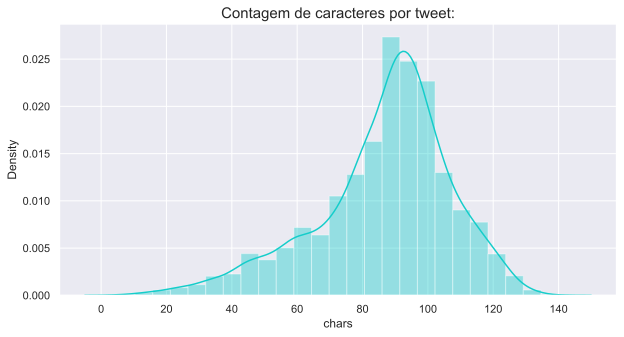

In [19]:
tweets_df['chars'] = tweets_df['text'].str.len()

char_min = tweets_df['chars'].min()
char_max = tweets_df['chars'].max()
char_med = tweets_df['chars'].mean()

# Plotar gráfico
plt.figure(figsize=(10,5))
sns.set_color_codes()
axis = sns.distplot(tweets_df['chars'], color="#15CDCA", bins=25)
axis.set_title("Contagem de caracteres por tweet:", fontsize=15)


# Salvar imagem
plt.savefig("char_counter_tweets.png", bbox_inches="tight", pad_inches=0.5)

print(f'Contagem de caracteres por Tweet:\n'
      f'Contagem mínima: {char_min}\n'
      f'Contagem máxima: {char_max}\n'
      f'Contagem média: {round(char_med)}')

### Quais os usuários mais ativos?

Quais são os usuários que mais postaram sobre o assunto, e quantos tweets postaram?

***Observação***

Como a coluna de `user` é composta por dicionários com as informações dos usuários, deve-se extrair as informações que irão ser utilizadas e atribui-las a colunas novas dentro do dataframe. 

Isso irá ser feito com:

● Nomes dos usuários -> coluna `username`

● Informações de localização do usuário -> coluna `derivated`

In [20]:
tweetsUsers = tweets_df['user']

users_list = pd.DataFrame.from_records(tweetsUsers)

tweets_df['username'] = users_list['screen_name']
tweets_df['derived'] = users_list['derived']

Agrupa-se a ocorrência dos nomes dos usuários para entender quais são os que aparecem mais vezes ao longo do dataframe, o que significa, os nomes que fizeram mais postagens.

In [21]:
names_list = users_list["screen_name"].tolist()
occurrences = collections.Counter(names_list)

names_df = pd.DataFrame({"Total":list(occurrences.values())}, index=occurrences.keys())
names_sorted = names_df.sort_values("Total", ascending=False)
names_sorted = names_sorted.head(25)

Text(0.5, 1.0, 'Usuários com mais postagens:')

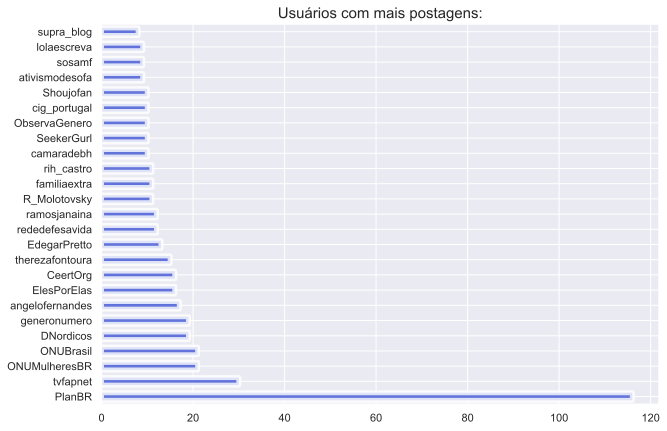

In [22]:
# Plotar gráfico
my_range=list(range(1,len(names_sorted.index)+1))
axis = names_sorted.Total.plot(kind="barh",color="#3E54D3", alpha=0.8, linewidth=5, figsize=(10,7), x="users", y="tweets")
axis.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
axis.set_title("Usuários com mais postagens:", fontsize=15)


# Salvar imagem
plt.savefig("names_tweets.png", bbox_inches="tight", pad_inches=0.5)

### Qual o tweet mais curtido e retweetado?

No próprio dataframe já veem as informações sobre o número de curtidas e retweets de cada tweet coletado, nas colunas `favorite_count` e `retweet_count`. Portanto, basta buscar em todo dataframe quais tweets tem a maior contagem nessas respectivas colunas.

In [23]:
likes_max = np.max(tweets_df['favorite_count'])

likes = tweets_df[tweets_df.favorite_count == likes_max].index[0]

print(f"O tweet com mais curtidas é: {tweets_df['full_text'][likes]}")
print(f"Número de curtidas: {likes_max}")
print(f"Foi postado em: {tweets_df['publication_year'][likes]}")
print(f"Pelo(a) usuário(a): {tweets_df['username'][likes]}")

O tweet com mais curtidas é: Marta saiu do interior de Alagoas. É mais fenômeno que qualquer macho batendo bola. Por que não se aposenta milioná… https://t.co/7qOKfTfpT4
Número de curtidas: 2683
Foi postado em: 2018
Pelo(a) usuário(a): nan


In [24]:
retweet_max = np.max(tweets_df['retweet_count'])

retweet = tweets_df[tweets_df.retweet_count == retweet_max].index[0]

print(f"O tweet com mais retweets é: {tweets_df['full_text'][retweet]}")
print(f"Número de retweets: {retweet_max}")
print(f"Foi postado em: {tweets_df['publication_year'][retweet]}")
print(f"Pelo(a) usuário(a): {tweets_df['username'][retweet]}")

O tweet com mais retweets é: Marta saiu do interior de Alagoas. É mais fenômeno que qualquer macho batendo bola. Por que não se aposenta milioná… https://t.co/7qOKfTfpT4
Número de retweets: 790
Foi postado em: 2018
Pelo(a) usuário(a): nan


### ECDF da quantidade de tweets, retweets e curtidas

A ECDF (função de distribuição empírica) de tweets nos dá bem mais informações sobre os dados coletados. 

Praticamente 90% de toda a base de usuários possui menos de 10 tweets porém existem outliers de usuários com algo próximo aos 20 tweets. 

Já sobre a quantidade de retweets, percebemos que praticamente 99% da base tem menos de 100 retweets, a maioria ficando com 0 retweets. Porém, com outliers de usuários com mais de 400 retweets.

Já sobre a quantidade de curtidas, percebemos que praticamente 99% da base tem menos de 200 curtidas. Porém, com outliers de usuários com tweets com mais de 1000 curtidas.

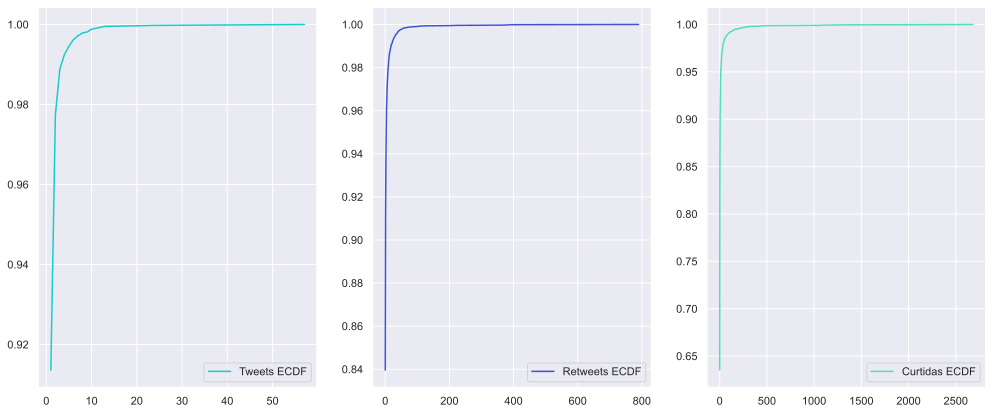

In [25]:
fig, axis = plt.subplots(nrows=1, ncols=3, figsize=(17, 7))
tweet_count = (tweets_df
                .groupby("username")
                .agg({"text": "count"})["text"].sort_values().values)

retweet_count = (tweets_df["retweet_count"].sort_values().values)

likes_count = (tweets_df["favorite_count"].sort_values().values)

tweet_count_ecdf, retweet_count_ecdf, likes_count_ecdf = (map(ECDF, [tweet_count, retweet_count, likes_count]))

# Plotar gráfico
axis[0].plot(tweet_count, tweet_count_ecdf(tweet_count), color="#15CDCA")
axis[0].legend(labels=["Tweets ECDF"], loc=4)
axis[0].get_legend().legendHandles[0].set_color("#15CDCA")

axis[1].plot(retweet_count, retweet_count_ecdf(retweet_count), color="#3E54D3")
axis[1].legend(labels=["Retweets ECDF"], loc=4)
axis[1].get_legend().legendHandles[0].set_color("#3E54D3");

axis[2].plot(likes_count, likes_count_ecdf(likes_count), color="#4FE0B6")
axis[2].legend(labels=["Curtidas ECDF"], loc=4)
axis[2].get_legend().legendHandles[0].set_color("#4FE0B6");

# Salvar imagem
plt.savefig("ECDF_tweets.png", box_inches="tigh", pad_inches=0.5)

### Como a quantidade de curtidas e retweets e o tamanho do tweet se relacionam?

Uma forma de identificar possíveis relações entre colunas é utilizando correlação (`.corr` da biblioteca `pandas`).

Através da correlação, mede-se qual é o grau com que duas variáveis se relacionam, mas essa correlação entre as duas variaveis nao implica causalidade entre elas. O método de correlação devolve um número de -1 a 1, onde quanto mais próximo das extremidades (-1 e 1), mais forte é a correlação entre as duas colunas e, quanto mais próximo de zero, mais fraca a correlação. 

In [26]:
tweets_df[["favorite_count", "retweet_count", "chars"]].corr()

,favorite_count,retweet_count,chars
favorite_count,1.000000,0.820167,0.009736
retweet_count,0.820167,1.000000,0.003860
chars,0.009736,0.003860,1.000000


Com a tabela acima, pode-se perceber que as colunas de favoritos e retweets tem uma grande correlação (0.82). 

Potanto, filtra-se os valores de retweets e favoritos com mais ocorrências para possibilitar uma melhor observação  do gráfico. Onde tem-se uma distribuição “diretamente proporcional” entre os valores das duas colunas.

<AxesSubplot:xlabel='retweet_count', ylabel='favorite_count'>

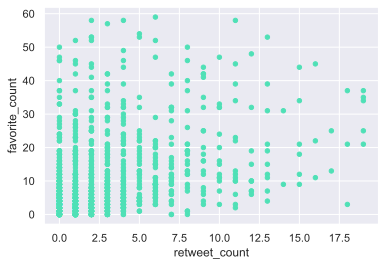

In [27]:
# Plotar gráfico
tweets_df[tweets_df["retweet_count"]<20][tweets_df["favorite_count"]<60].plot.scatter(x="retweet_count", y="favorite_count", color="#4FE0B6");

# Salvar imagem
plt.savefig('correlation_columns.png', bbox_inches='tight', pad_inches=0.5)

### Quais as palavras mais atribuídas?

#### Usando a biblioteca `nltk`.

Pode-se verificar facilmente as palavras mais frequentes dos tweets.


Primeiramente, divide-se os textos dos tweets através da tokenização, e checa-se as palavras mais frequentes com mais de 3 caracteres.

Abaixo, lista-se as 25 palavras (com mais de 3 caracteres) mais frequentes.

Text(0.5, 1.0, 'Palavras mais frequentes:')

<AxesSubplot:title={'center':'Palavras mais frequentes:'}, ylabel='Palavra'>

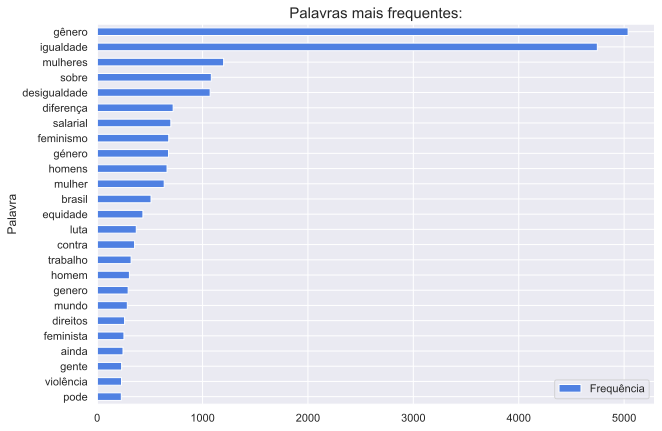

In [28]:
tweet_words = tweet_tokenizer.tokenize(tweets_df["text"].drop_duplicates().str.lower().str.cat(sep=" ")) # separa em palavras
word_dist = fp.pipe(fp.keyfilter(lambda x: len(x) > 3, nltk.FreqDist(tweet_words)), # apenas palavras com mais de 3 caracteres
                    nltk.probability.FreqDist)

fig, axis = plt.subplots(figsize=(10, 7))
axis.set_title("Palavras mais frequentes:", fontsize=15)


(pd.DataFrame(word_dist.most_common(25)[::-1],
              columns=["Palavra", "Frequência"])
    .plot(x="Palavra", y="Frequência", ax=axis, color = "#4F80E2", kind="barh"));
          
# Salvar imagem
plt.savefig("most_common_words.png", box_inches="tigh", pad_inches=0.5)

#### Usando a biblioteca `WordCloud`.

Com esta outra biblioteca, pode-se apresentar a famosa nuvem de palavras mais atribuidas.

(-0.5, 399.5, 199.5, -0.5)

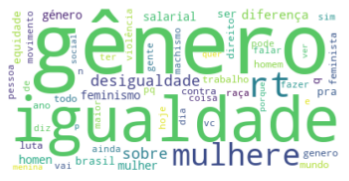

In [29]:
tweets_df['text'] = np.where(tweets_df['text'].isnull(),"",tweets_df['text'])

words = ' '.join(tweets_df['text'])

words_clean = " ".join([word for word in words.split()])

warnings.simplefilter('ignore')

wordCloud = WordCloud(
    max_words=1000, max_font_size=100,
               min_font_size=10, random_state=42,
               background_color='white', mode="RGB",
               collocations=False,normalize_plurals=True).generate(words_clean)



# Plotar gráfico
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis("off")


# Salvar imagem
plt.savefig('tweets_cloud.png', dpi=500)
plt.show()

### Quais são as hashtags mais utilizadas?

Para identificar as hashtags que mais aparecem nos tweets, precisa-se extrai-las do texto. Portanto, cria-se uma função que ao indentificar uma `#` no texto dos tweets, adiciona-a em uma lista de hashtags. 

Posteriormente, verifica-se a frequência das hashtags nesta lista para identificar as que foram mais frenquentes.

In [30]:
def collectHashtags(text, hashtags):
    for word in text.split():
        if word[0] == '#':           
            hashtags.append(word)

In [31]:
hashtag_list = []
for tweet in tweets_df['text']:
    collectHashtags(tweet, hashtag_list)

In [32]:
occurrences = collections.Counter(hashtag_list)

hashtags_df = pd.DataFrame({'Total':list(occurrences.values())}, index=occurrences.keys())
hashtags_sorted = hashtags_df.sort_values('Total', ascending=False)
hashtags_sorted = hashtags_sorted.head(10)

Text(0.5, 1.0, 'Hashtags mais frequentes:')

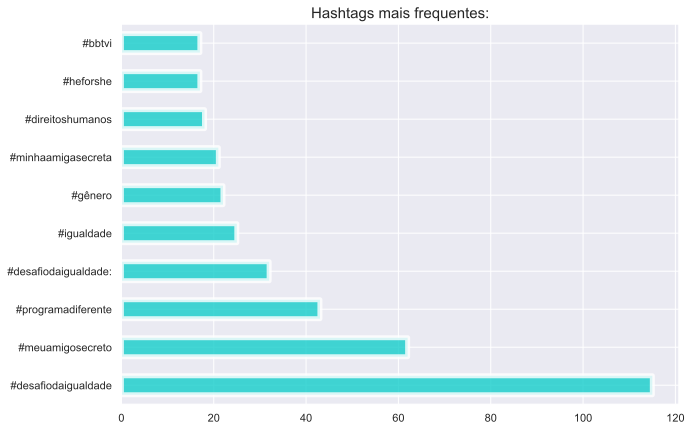

In [33]:
# Plotar gráfico
my_range=list(range(1,len(hashtags_sorted.index)+1))
axis = hashtags_sorted.Total.plot(kind='barh',color='#15CDCA', alpha=0.8, linewidth=5, figsize=(10,7), x="users", y="tweets")
axis.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
   

# Salvar imagem
axis.set_title("Hashtags mais frequentes:", fontsize=15)
plt.savefig('hashtags_tweets.png', bbox_inches='tight', pad_inches=0.5)

### Indice de tweets por data de criação

Através da coluna `publication_year` pode-se identificar uma "linha do tempo" da quantidade de tweets por ano de publicação. O que pode nos permitir associar a quantidade de tweets com algo que aconteceu e gerou revolta nas redes sociais.

<AxesSubplot:xlabel='publication_year', ylabel='num_tweets'>

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, '2015'),
  Text(1, 0, '2016'),
  Text(2, 0, '2017'),
  Text(3, 0, '2018'),
  Text(4, 0, '2019'),
  Text(5, 0, '2020'),
  Text(6, 0, '2021')])

Text(0.5, 1.0, 'Linha do tempo dos tweets:')

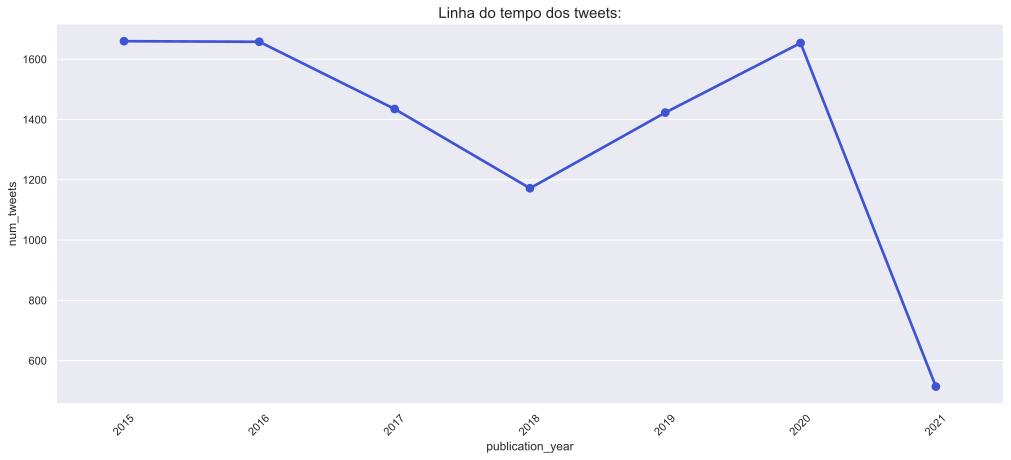

In [34]:
# Plotar gráfico
fig, axis = plt.subplots(figsize=(17, 7))
sns.pointplot(data=(tweets_df
                        .assign(publication_date=tweets_df["publication_year"].dt.strftime("%Y"))
                        .groupby("publication_year")["text"]
                        .count()
                        .reset_index() 
                        .rename(columns={"text": "num_tweets"})),
              x="publication_year",
              y="num_tweets",
              ax=axis,
              color= "#3E54D3")
plt.xticks(rotation=45);


# Salvar imagem
axis.set_title("Linha do tempo dos tweets:", fontsize=15)
plt.savefig('timeline_tweets.png', bbox_inches='tight', pad_inches=0.5)

Com o gráfico acima, percebe-se claramente, que os anos de maiores publicações sao 2015, 2016 e 2020. Havendo uma queda nas publicações nos anos de 2018 e 2021. Para analisar-se melhor os números de postagens, segue o gráfico abaixo:

<AxesSubplot:ylabel='publication_year'>

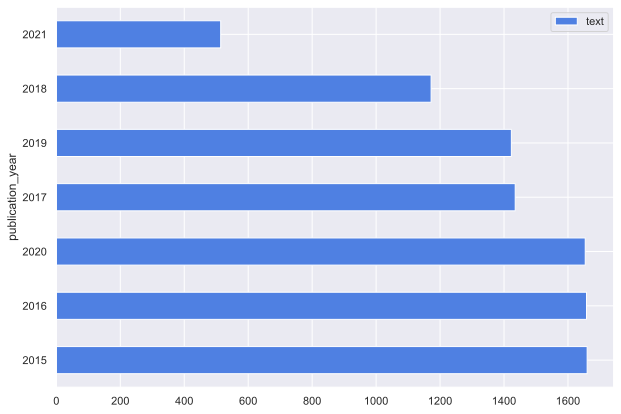

In [35]:
# Plotar gráfico
fig, axis = plt.subplots(figsize=(10, 7))
(tweets_df
     .groupby("publication_year")
     .agg({"text": "count"})
     .sort_values(by="text", ascending=False)
     .head(100).plot(ax=axis, color= "#4F80E2", kind="barh"));


# Salvar imagem
plt.savefig('years_tweets.png', bbox_inches='tight', pad_inches=0.5)

### De quais regiões vieram os tweets?

Através da coluna `derivated` pode-se obter as informações dos locais de publicação dos tweets. Importante lembrar que, apenas os usuários que permitiram o acesso a sua localização, virão com esta informação não-nula nesta coluna, esta, sendo um dicionário com a localização, endereço, e etc.

Já que apenas serão utilizadas as localizações não-nulas, não pode-se criar uma coluna dentro do dataframe `tweets_df` para armazenar esta informação, já que esta pode ser menor do que o mesmo. Para isto, cria-se um dataframe auxiliar: `locations_list`.

In [36]:
locations = []
for tweet in tweets_df['derived']:
    if type(tweet) != float: #checando se é Nan
        locations.append(tweet.get('locations'))
        
locations_list = pd.DataFrame.from_records(locations)
locations_list['location'] = pd.DataFrame.from_records(locations)

Extraindo o endereço das localizações coletadas acima. Criando uma coluna de endereços para cada localização: `locations_list['addresses']`.

In [37]:
adresses = []

for location in locations_list['location']:
    adresses.append(location.get('full_name'))

locations_list['addresses'] = adresses

Através da biblioteca do `geolocator`, pode-se identificar as latitudes e longitudes dos endereços coletados acima. Permitindo, desta forma, a apresentação de uma mapa de calor dos tweets.

****Observação****

Aconselha-se que esta parte do código fique comentada já que demora muito para ser compilada. Apenas descomentar caso desejar ver ou salvar o mapa de calor.

In [38]:
geolocator = Nominatim(user_agent="tweeter_analysis")

latitude = []
longitude = []

for address in adresses:
  try:
    location = geolocator.geocode(address)
    latitude.append(location.latitude)
    longitude.append(location.longitude)
  except:
    continue

In [39]:
# Plotar gráfico
coordinates = np.column_stack((latitude, longitude))
heat_map = folium.Map(zoom_start=3.)
heat_map.add_child(plugins.HeatMap(coordinates))

Além do mapa de calor, pode-se analisar os locais que ocorreram mais postagens analisando as ocorrências dos endereços na coluna criada anteriormente.

In [40]:
addresses_list = locations_list['addresses'].tolist()
occurrences = collections.Counter(addresses_list)

addresses_df = pd.DataFrame({'Total':list(occurrences.values())}, index=occurrences.keys())
addresses_sorted = addresses_df.sort_values('Total', ascending=False)
addresses_sorted = addresses_sorted.head(25)

Text(0.5, 1.0, 'Regiões com mais postagens:')

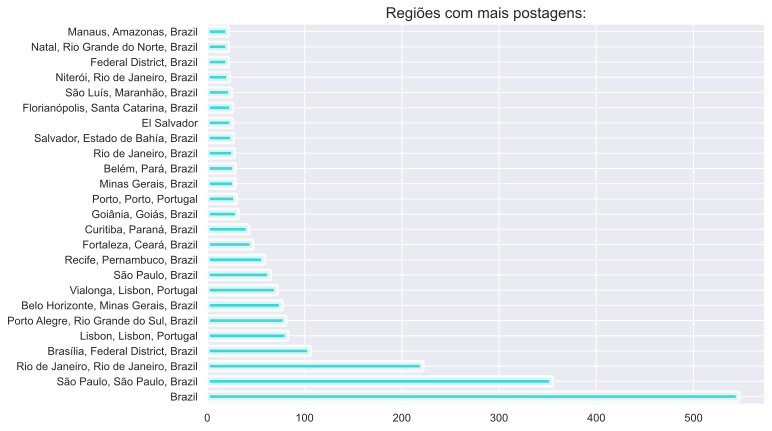

In [41]:
# Plotar gráfico
my_range=list(range(1,len(addresses_sorted.index)+1))
axis = addresses_sorted.Total.plot(kind='barh',color='#15CDCA', alpha=0.8, linewidth=5, figsize=(10,7), x="endereços", y="tweets")
axis.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
axis.set_title("Regiões com mais postagens:", fontsize=15)   

# Salvar imagem
plt.savefig('addresses_tweets.png', bbox_inches='tight', pad_inches=0.5)

# Análises com NLP

## Análise do conteúdo das postagens

#### Explorar Palavras Coocorrentes 

Para identificar a coocorrência de palavras nos tweets, pode-se usar `ngrams` da biblioteca `nltk`.

***Bigramas***

Começa-se analisando os bigramas, ou seja, sequências de 2 palavras co-ocorrentes nos tweets. Para isso, cria-se as listas dos biagramas e dos trigramas para armazenar as palavras encontradas.

In [42]:
tweet_tokenizer = TweetTokenizer() 
terms_bigram = []
terms_trigram = []

for tweet in tweets_df['text']:
    token = tweet_tokenizer.tokenize(tweet)
    bigram = list(ngrams(token, 2)) 
    trigram = list(ngrams(token, 3)) 
    terms_trigram.append(trigram)
    terms_bigram.append(bigram)

Agora, conta-se a ocorrência dos bigramas na lista `terms_bigram` para apresentar os 10 mais frequentes.

In [43]:
bigrams = list(itertools.chain(*terms_bigram))
bigram_counts = collections.Counter(bigrams)

bigram_df = pd.DataFrame(bigram_counts.most_common(10),
                             columns=['Bigramas', 'Ocorrências'])

bigram_df

,Bigramas,Ocorrências
0,"(igualdade, gênero)",3251
1,"(desigualdade, gênero)",736
2,"(gênero, ,)",725
3,"(igualdade, género)",547
4,"(diferença, salarial)",516
5,"(gênero, .)",458
6,"(sobre, igualdade)",416
7,"(equidade, gênero)",312
8,"(homens, mulheres)",238
9,"(igualdade, genero)",224


***Trigramas***

Agora, analisaremos os trigramas, ou seja, sequências de 3 palavras co-ocorrentes nos tweets.

Contando a ocorrência dos trigramas adicionados na lista `terms_trigram` para apresentar os 10 mais frequentes.

In [44]:
trigrams = list(itertools.chain(*terms_trigram))
trigram_counts = collections.Counter(trigrams)

trigram_df = pd.DataFrame(trigram_counts.most_common(10),
                             columns=['Trigramas', 'Ocorrências'])

trigram_df

,Trigramas,Ocorrências
0,"(igualdade, gênero, ,)",481
1,"(sobre, igualdade, gênero)",322
2,"(igualdade, gênero, .)",314
3,"(diferença, salarial, homens)",145
4,"(salarial, homens, mulheres)",143
5,"(luta, igualdade, gênero)",139
6,"(,, igualdade, gênero)",124
7,"(igualdade, gênero, ?)",110
8,"(!, !, !)",93
9,"(fórum, econômico, mundial)",88


## Análise de sentimento 

### Analisando o dataset que será utilizado para treino.


Para treinar o modelo, usaremos um dataset pronto contendo dados que foram coletados pelo governo de Minas Gerais, estes dados são um conjunto de tweets em língua portuguesa que já foram classificados com sentimentos negativos, positivos e neutros, retirado do github [minerando dados](https://github.com/minerandodados/mdrepo).

In [45]:
training_dataset = pd.read_csv("./Tweets_Mg.csv", encoding='utf-8')
training_dataset.head()
training_dataset.shape

,Unnamed: 0,Created At,Text,Geo Coordinates.latitude,Geo Coordinates.longitude,User Location,Username,User Screen Name,Retweet Count,Classificacao,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,0,Sun Jan 08 01:22:05 +0000 2017,���⛪ @ Catedral de Santo Antônio - Governador Valadares/MG https://t.co/JSbKamIqUJ,NaN,NaN,Brasil,Leonardo C Schneider,LeoCSchneider,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Sun Jan 08 01:49:01 +0000 2017,"� @ Governador Valadares, Minas Gerais https://t.co/B3ThIDJCSf",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Sun Jan 08 01:01:46 +0000 2017,"�� @ Governador Valadares, Minas Gerais https://t.co/dPkgzVR2Qw",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Wed Jan 04 21:43:51 +0000 2017,��� https://t.co/BnDsO34qK0,NaN,NaN,NaN,Ana estudando,estudandoconcur,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Mon Jan 09 15:08:21 +0000 2017,��� PSOL vai questionar aumento de vereadores e prefeito de BH na Justiça - Politica - Estado de Minas https://t.co/DMg7BGsek5,NaN,NaN,NaN,Emily,Milly777,0,Negativo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(8199, 26)

In [46]:
training_dataset['Classificacao'].value_counts()

Positivo    3300
Neutro      2453
Negativo    2446
Name: Classificacao, dtype: int64

### Contando a quantidade de tweets neutros, positivos e negativos

<AxesSubplot:>

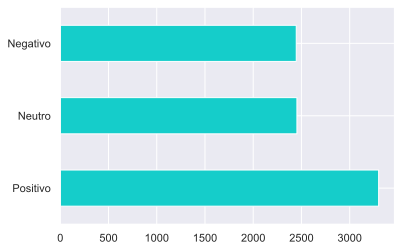

In [47]:
training_dataset['Classificacao'].value_counts().plot(kind='barh',color="#15CDCA" )

In [48]:
tweets = training_dataset['Text'].values
classification = training_dataset['Classificacao'].values

In [49]:
tweets = [cleanTweet(tweet) for tweet in tweets]

### Análise com a biblioteca NLTK

Como já explicado anteriormente, NLTK é uma biblioteca que contém pacotes para fazer com que as máquinas entendam a linguagem humana.

#### Treino de modelo de Machine Learning:

***O treinamento do modelo será feito usando a abordagem Bag of Words e o algoritmo Naive Bayes Multinomial.***


   - `bag of words` -> treina o modelo com um vetor que contém as palavras da base e suas respectivas frequências.
   - `fit_transform` -> ajusta o modelo, aprendendo o vocabulário e transformando os dados de treinamento em vetores com frequêcia das palavras

Cria-se o modelo para classificar os tweets em positivo, negativo ou neutro, como esperado pelo dataset acima que utilizaremos para o treino.

Utiliza-se o CountVectorizer para tokenizar os texto e criar um vocabulário de palavras conhecidas.

In [50]:
vectorizer = CountVectorizer(analyzer="word", tokenizer=tweet_tokenizer.tokenize)
freq_tweets = vectorizer.fit_transform(tweets)
type(freq_tweets)
freq_tweets.shape

# Treinamento do modelo de Machine Learning
model = MultinomialNB()
model.fit(freq_tweets,classification)

scipy.sparse.csr.csr_matrix

(8199, 7348)

MultinomialNB()

In [51]:
freq_tweets.A

array([[0, 0, 0, ..., 0, 0, 3],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 2],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### Testando o modelo com os tweets coletados sobre desigualdade de genêro

In [52]:
tests = tweets_df['text']

In [53]:
# Transformando os dados de teste em vetores de palavras:
freq_testes = vectorizer.transform(tests)

In [54]:
# Probabilidades de cada classe
print (model.classes_)
model.predict_proba(freq_testes).round(2)

['Negativo' 'Neutro' 'Positivo']


array([[0.13, 0.83, 0.04],
       [0.31, 0.59, 0.1 ],
       [0.95, 0.05, 0.  ],
       ...,
       [0.05, 0.95, 0.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  ]])

In [55]:
sentiments = []
# Classificação com o modelo treinado:
for tweet, sentiment in zip (tests,model.predict(freq_testes)):
    print (tweet +", "+ sentiment)
    sentiments.append(sentiment)

#projetothebridge:a mulher angolana desenvolvimento sustentável objetivo construir igualdade gênero., Neutro
igualdade género fez suécia país rico, Neutro
@camy_dragen exatamente! tão famigerada igualdade vai existir papéis gênero ñ existirem +, serve pro homem tbm, Negativo
muitos vêm femeninistas. gente outro modo diz defensora igualdade género......, Neutro
livra armero trás chiquinho, difícil compreender... 6 p meia dúzia.. diferença eh apenas questão salarial, Neutro
oiça mariana magalhães, educadora infância, dizer sobre igualdade género. concorda?, Neutro
nao sei pq... cadê papo igualdade gênero?, Neutro
@_maialuu igualdade gênero presente forte 2016!, Neutro
favor feminismo, igualdade gênero, contra violência mulher etc.. cara, mulher problematiza cada coisa, Neutro
rt @onubrasil: unfpa apoia evento sobre participação política igualdade gênero países língua portuguesa, Neutro
@lttlwhtls triste deturparam imagem feminismo, igualdade gênero etc, agora raça suprema bla bla bla, Ne

m l q u ganhou concursinho desigualdade gênero música colégio x ué, Neutro
@rodbastos sei disso. medo ê mudarem colocando meio homens.. perdi fé igualdade gênero séries.., Negativo
diferença salarial sobe estado rico -&gt; quanto rico estado brasileiro, maior diferença salários de..., Neutro
@_erickjunio pode fazer diferença quesito querer abaixar pedida salarial, Neutro
orgulho aaaaa ❤❤❤, Neutro
sempre pra polemizar, perguntei pro colega q achava igualdade gênero, Neutro
desigualdade gênero: mulheres trabalham cinco horas ganham 76% salário homens..., Positivo
rt @onumulheresbr: confira publicação vieses inconscientes sobre equidade gênero mundo corporativo: via @…, Negativo
#eueducosemmachismo porque escola meninas! #desafiodaigualdade,saiba mai em..., Positivo
serena williams escreveu poderosa carta aberta sobre desigualdade gênero machismo "para todas as..., Neutro
premiação concurso vozes igualdade gênero, promovido secretaria estadual educação sp pelo..., Positivo
premiação concu

77% geração z (jovens 2018 14 25 anos) acredita igualdade gênero super importante…, Neutro
"então, termo “igualdade gêneros” faz sentido porque, definição, gênero hierarquia, dual…, Neutro
mãe - porque n feminista - voce feminista - - sim, acredita igualdade genero - si…, Neutro
falo "sou contra feminismo" contra igualdade gênero. contra seita coletivista, minor…, Positivo
pensar "mary poppins' filme 1964, bicho. murro machismo americano tratar temas importante…, Neutro
"é preciso deixar lado ideia educação solução todos problemas. redução desigualdade ser…, Neutro
desigualdades sociais: fenômeno complexo dados acima referem desigualdade econômica: renda, riqueza,…, Negativo
rt @janiane_: aí cara manja assunto, tipo racismo, desigualdade gênero, economia, música, sei lá. faz favor fic…, Neutro
rt @joaocravinho: parabéns noemie freire, parabéns marinha marco caminhada igualdade género forças armadas…, Positivo
meninas super poderosa sempre desenho favorito, poço sonoridade, igualdade gê

ainda falta atingirmos igualdade gênero serviço público federal. enquanto deixam me…, Neutro
kkkkkkkk tão estranho tudo torna discussão política twitter tipo, mc rebecca deu iphone uns…, Neutro
@hugo_tx_ @mmateussss autora bro. olha igualdade género, Negativo
estatuto igualdade racial prevê desigualdade gênero raça assimetria existente âmbito soc…, Negativo
opinião | "nossas desigualdades derivam parte racismo estrutural desigualdade gênero, bem dis…, Neutro
pode haver diferença salarial vendedores trabalham lojas diferentes mesma empresa) -, Neutro
@taoquei1 países árabes capitalistas aliados comerciais perseguindo imprensa perpetuando desigualdade gê…, Negativo
@gugachacra cara matou jogou corpo acido dissidente, prenderiam mulher quer igualdade de…, Neutro
@parox40 hora difícil pra defender igualdade gênero país acha conservador religioso., Neutro
6 feminicídios brasil feriado natal @cnj_oficial propõe endurecimento penas resolução pr…, Neutro
rt @maria11terra: vacina plano vacinaçã

In [56]:
tweets_df['sentiment'] = sentiments
tweets_df['sentiment'].head()

0      Neutro
1      Neutro
4    Negativo
5      Neutro
6      Neutro
Name: sentiment, dtype: object

### Apresentando a quantidade de tweets neutros, positivos e negativos.

In [57]:
pos_tweets = []
neg_tweets = []
neut_tweets = []

for sentiment in tweets_df['sentiment']:
    if sentiment == 'Positivo':
        pos_tweets.append(sentiment)
    elif sentiment == 'Neutro' :
         neut_tweets.append(sentiment)
    else:
        neg_tweets.append(sentiment)

In [82]:
print("Tweets classificados como positivos: {}".format(len(pos_tweets)))
print("Tweets classificados como negativos: {}".format(len(neg_tweets)))
print("Tweets classificados como neutros: {}".format(len(neut_tweets)))

Porcentagem de Tweets Positivos: 1648
Porcentagem de Tweets Negativos: 1519
Porcentagem de Tweets Neutros: 6349


In [59]:
sentiments = ['Positivos', 'Negativos', 'Neutros']
percents = [len(pos_tweets), len(neg_tweets), len(neut_tweets)]

<AxesSubplot:>

Text(0.5, 1.0, 'Porcentagem por Sentimento:')

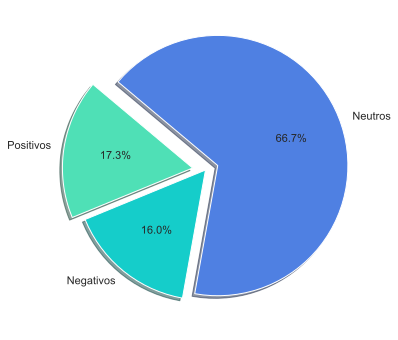

In [83]:
# Plotar gráfico
pie_chart = pd.Series(percents, index=sentiments, name='')
pie_chart.plot.pie(fontsize=11, autopct='%1.1f%%', shadow=True, startangle=140, figsize=(6, 6), explode=(0.1, 0, 0.1), colors = ['#4FE0B6', '#15CDCA', '#4F80E2']);

# Salvar imagem
axis.set_title("Porcentagem por Sentimento:", fontsize=15)   
plt.savefig('sentiments1_tweets.png', bbox_inches='tight', pad_inches=0.5)

Pode-se perceber que a maior parte dos tweets foram classificados como neutros.

### Distribuição de sentimentos por ano de publicação:

Text(0.5, 1.0, 'Distribuição de sentimentos por ano de publicação:')

<AxesSubplot:title={'center':'Distribuição de sentimentos por ano de publicação:'}, xlabel='publication_year', ylabel='num_tweets'>

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, '2015'),
  Text(1, 0, '2016'),
  Text(2, 0, '2017'),
  Text(3, 0, '2018'),
  Text(4, 0, '2019'),
  Text(5, 0, '2020'),
  Text(6, 0, '2021')])

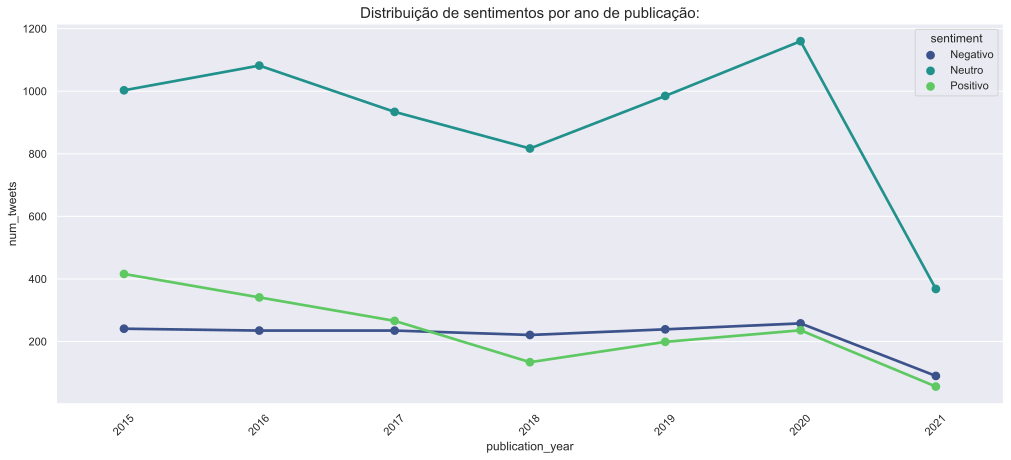

In [85]:
fig, axis = plt.subplots(figsize=(17, 7))
axis.set_title("Distribuição de sentimentos por ano de publicação:", fontsize=15)   
sns.pointplot(data=(tweets_df
                        .assign(publication_date=tweets_df["publication_year"].dt.strftime("%Y"))
                        .groupby(["publication_year", "sentiment"])["text"]
                        .count()
                        .reset_index() 
                        .rename(columns={"text": "num_tweets"})),
              x="publication_year",
              y="num_tweets",
              hue="sentiment",
              ax=axis,
              palette="viridis")
plt.xticks(rotation=45);
plt.savefig('sentiments2_tweets.png', bbox_inches='tight', pad_inches=0.5)

Além do pico de tweets analisados como neutros em 2020, podemos analisar uma leve queda dos tweets positivos em 2018. Sendo que estes se mantinham mais frequentes que os negativos em 2015, 2016 e 2017.

### Melhorando o modelo

#### Tags de Negações

Acrescenta uma `tag _NEG` após um ‘não’.

Objetivo é dar mais peso para o modelo identificar uma inversão de sentimento da frase.

In [62]:
# Função para aplicar as tags de negação:
def applyNegTag(tweet):
    neg = ['não']
    neg_tag = False
    result = []
    words = tweet.split()
    for word in words:
        word = word.lower()
        if neg_tag == True:
            word = word + '_NEG'
        if word in neg:
            neg_tag = True
        result.append(word)
    return (" ".join(result))

#### Criando modelos com Pipelines

Pipeline é um modulo da biblioteca `sklearn` que permite agrupar transformadores e preditores. Vantagens de utilizar pipelines: Melhora a produtividade, facilita o uso de técnicas de validação e seleção de modelos. Portanto, estas são interessantes para reduzir código e automatizar fluxos.

In [63]:
# Vetorizando os dados e passando o classificador:
pipeline_linear = Pipeline([
  ('counts', CountVectorizer()),
  ('classifier', MultinomialNB())
])
pipeline_linear.fit(tweets,classification)

Pipeline(steps=[('counts', CountVectorizer()), ('classifier', MultinomialNB())])

In [64]:
# Pipeline que atribui tag de negações nas palavras:
pipeline_neg = Pipeline([
  ('counts', CountVectorizer(tokenizer=lambda text: applyNegTag(text))),
  ('classifier', MultinomialNB())
])
pipeline_neg.fit(tweets,classification)

Pipeline(steps=[('counts',
                 CountVectorizer(tokenizer=<function <lambda> at 0x7f9fef9fce50>)),
                ('classifier', MultinomialNB())])

### Avaliando o modelo através de métricas de avaliação:

#### Validando os Modelos com Validação Cruzada

Deve-se separar os dados de treino e teste em 10 partes distintas e para cada parte, dessa forma, o modelo vai treinar o algoritmo e testar.

In [95]:
def giveMetrics(model, tweets, classification):
    results = cross_val_predict(model, tweets, classification, cv=10)
    print('Acurácia do modelo: {}'.format(metrics.accuracy_score(classification,results)))
    print(metrics.classification_report(classification,results,all_sentiments))
    print(pd.crosstab(classification, results, rownames=['Real'], colnames=['Predito'], margins=True))

#### Acurácia:

Indica uma performance geral do modelo. Dentre todas as classificações, quantas o modelo classificou corretamente

#### Precisão, Revocação e F1-score:

A biblioteca `sklearn`, possui uma função chamada `classification_report`, que entrega todas as métricas de precisão, revocação e F1-score do modelo desejado.

#### Matriz de confusão:

Uma matriz de confusão é uma tabela que indica os erros e acertos do modelo, comparando com o resultado esperado.

### Modelos Naive Bayes:

#### Simples -> sem tag de negação

In [92]:
giveMetrics(pipeline_linear, tweets, classification)

Acurácia do modelo: 0.8766922795462861
              precision    recall  f1-score   support

    Positivo       0.95      0.87      0.91      3300
    Negativo       0.88      0.92      0.90      2446
      Neutro       0.79      0.84      0.81      2453

    accuracy                           0.88      8199
   macro avg       0.87      0.88      0.87      8199
weighted avg       0.88      0.88      0.88      8199

Predito   Negativo  Neutro  Positivo   All
Real                                      
Negativo      2245     192         9  2446
Neutro         258    2060       135  2453
Positivo        49     368      2883  3300
All           2552    2620      3027  8199


#### Com tag de negação

In [94]:
giveMetrics(pipeline_neg, tweets, classification)

Acurácia do modelo: 0.7087449688986461
              precision    recall  f1-score   support

    Positivo       0.73      0.83      0.78      3300
    Negativo       0.76      0.66      0.71      2446
      Neutro       0.64      0.59      0.61      2453

    accuracy                           0.71      8199
   macro avg       0.71      0.69      0.70      8199
weighted avg       0.71      0.71      0.71      8199

Predito   Negativo  Neutro  Positivo   All
Real                                      
Negativo      1620     386       440  2446
Neutro         408    1443       602  2453
Positivo       115     437      2748  3300
All           2143    2266      3790  8199


# Análise com uma Rede Neural

## Previsão de engajamento em postagens

A partir de um modelo treinado, pode-se prever a partir do engajamento dos tweets coletados, ou seja, atraves do numero de retweets e curtidas, qual a possibilida de engajamento em outras publicacoes. Esta previsao além de levar em conta as curtidas e retweets, leva em consideracao, as palavras que continham nos tweets e nos titulos das postagens a serem previstas. 

#### Transformando as palavras em números
As redes neurais operam em números. Portanto, precisa-se transformar os tweets em números para que possa passá-los para a rede.

Para isso, utiliza-se a “Bag of Words” (já descrita anteriormente) onde cada palavra é definida como 1 (presente no tweet) ou 0 (não presente nno tweet). Nesse modelo, a ordem e a frequência das palavras não têm sentido.

In [73]:
def prepareTexts(text):
    stemmer = LancasterStemmer()
    stopWords = set(nltk.corpus.stopwords.words('portuguese'))
    text = re.sub('[^A-Za-z ]+', '', text)
    words = nltk.word_tokenize(text.lower())
    return [stemmer.stem(w.lower()) for w in words if w not in stopWords]

Para melhorar a precisão, será feito um pequeno pré-processamento no texto e, futuramente, nos títulos das publicações chamado stemming. Este, é o processo de reduzir palavras a um ancestral comum - portanto, “falar”, “falou” e “falando” seriam representados por um único nó nas entradas da rede, ao invés de três. Isso reduz o número de nós na rede, tornando a previsão mais rápida e, com sorte, mais precisa. 

In [74]:
def transformInBagOfWords(text, words):
    bag = []
    for word in words:
        bag.append(1) if word in text else bag.append(0)
    return bag

Acima, define-se a função que retorna o bag of words. Recebendo as palavras que foram selecionadas como palavras importantes para analise e o texto onde deve analisar se possui a palavra desejada. Retornando um array de uns e zeros representando a presença de uma palavra no tweet. 

In [75]:
words = []
final_words = []

for tweet in tweets_df['text']:
    words.extend(prepareTexts(tweet))
    
all_words = set(words)

for word in all_words:
    if words.count(word) > 5 and words.count(word) < 350: 
        final_words.append(word)

len(final_words)

2185

#### Treinando a rede neural

Para treinar, percore-se os tweets e cria-se duas matrizes - uma para as entradas (inputs), composta pelo bag of words e  outra para saídas (outputs), composta pelas a pontuação do tweet.

A pontuação é determinada pelo número de curtidas e retweets de cada tweet recebido.

Para a rede neural, usa-se o MLPRegressor do Scikit-learn. Este implementa um perceptron multicamadas onde pode-se definir o número de camadas ocultas. 

In [76]:
inputs = []
outputs = []

tweets_df['engagement'] = tweets_df['favorite_count'] + tweets_df['retweet_count'] 

for tweet in tweets_df['text']:
    text = prepareTexts(tweet)
    bag = transformInBagOfWords(text, final_words)
    inputs.append(bag)

for engagement in tweets_df['engagement']:
    score = min(engagement,1)
    outputs.append(score)

    
len(inputs)
len(outputs)

9516

9516

**Observação**

Define-se o número de nós ocultos como 50% das entradas, o conjunto discreto de palavras finais do bag of words.  Em seguida, 25%, o que resulta em uma rede com 4 camadas - entrada, 2 ocultas e, em seguida, uma saída.

In [77]:
neural_network = MLPRegressor(activation='relu', alpha=0.0001, hidden_layer_sizes=(int(len(final_words)*0.5),int(len(final_words)*0.25)),solver='adam', max_iter=400)
neural_network.fit(inputs, outputs)

MLPRegressor(hidden_layer_sizes=(1092, 546), max_iter=400)

#### Fazendo previsões

Agora que a rede neural está treinada, pode-se fazer previsões passando um pacote de palavras para o método de previsão.

Passando alguns feeds RSS, usando o módulo feedparser, passa-se os títulos das postagens para serem analisados e categorizados pelas rede. Esta, julgara a publicação pelo título e definirá se ela terá engajamento ou não.

Dos 6 feeds passados, são 4 relacionados ao tema de treinamento, ou seja, feeds com publicações apenas sobre desigualdade de genêro e os outros 2, são sore notícias gerais do mundo retiradas do site da BBC.

In [78]:
all_posts = {}

for url in ['https://www.cartacapital.com.br/tag/desigualdade-de-genero/feed/','https://brasil.elpais.com/arcio/rss/tags_slug/relaciones-genero-a/', 'chrome-extension://cdjocoacgphmbihenkkgaackgkjlfncp/pt/rss-feeds', 'http://www.bbc.co.uk/portuguese/topicos/internacional/index.xml', 'https://feed.podbean.com/podcast.gazetaonline.com.br/feed.xml', 'http://www.bbc.co.uk/portuguese/topicos/brasil/index.xml']:
    feed = feedparser.parse(url)
    for post in feed.entries:
        title = prepareTexts(post.title)
        bag = transformInBagOfWords(title, final_words)
        all_posts[post.title] = neural_network.predict([bag])[0]

In [79]:
top_posts = sorted(all_posts.items(), key=itemgetter(1), reverse=True)

top_posts_file = open("top_posts.txt", "w")
top_posts_file.write("Publicações que teriam mais engajamento:")
top_posts_file.write("\n")
top_posts_file.write("\n")

for post in top_posts[:5]: 
    title = functools.reduce(operator.add, (post[0]))
    top_posts_file.write(title)
    top_posts_file.write("\n")
    
top_posts_file.close()

40

1

1

46

1

82

1

68

1

71

1

82

1

In [80]:
bottom_posts = sorted(all_posts.items(), key=itemgetter(1), reverse=False)

bottom_posts_file = open("bottom_posts.txt", "w")
bottom_posts_file.write("Publicações que teriam menos engajamento:")
bottom_posts_file.write("\n")
bottom_posts_file.write("\n")

for post in bottom_posts[:5]: 
    title = functools.reduce(operator.add, (post[0]))
    bottom_posts_file.write(title)
    bottom_posts_file.write("\n")
    
bottom_posts_file.close()

41

1

1

46

1

67

1

77

1

70

1

62

1

***Observação***: 

Paleta de cores utilizada nos gráficos:

●  Verde Escuro = `#15CDCA`
●  Verde Claro = `#4FE0B6`
●  Roxo Escuro = `#3E54D3`
●  Roxo Claro = `#4F80E2`
● 